In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

In [ ]:
import os
print(os.getcwd())

c:\Users\criti\OneDrive\Desktop\New folder (2)


PeMS (Performance Measurement System) dataset

In [2]:
data_dir="./"
route_distances = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_V_228.csv"), header=None
).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


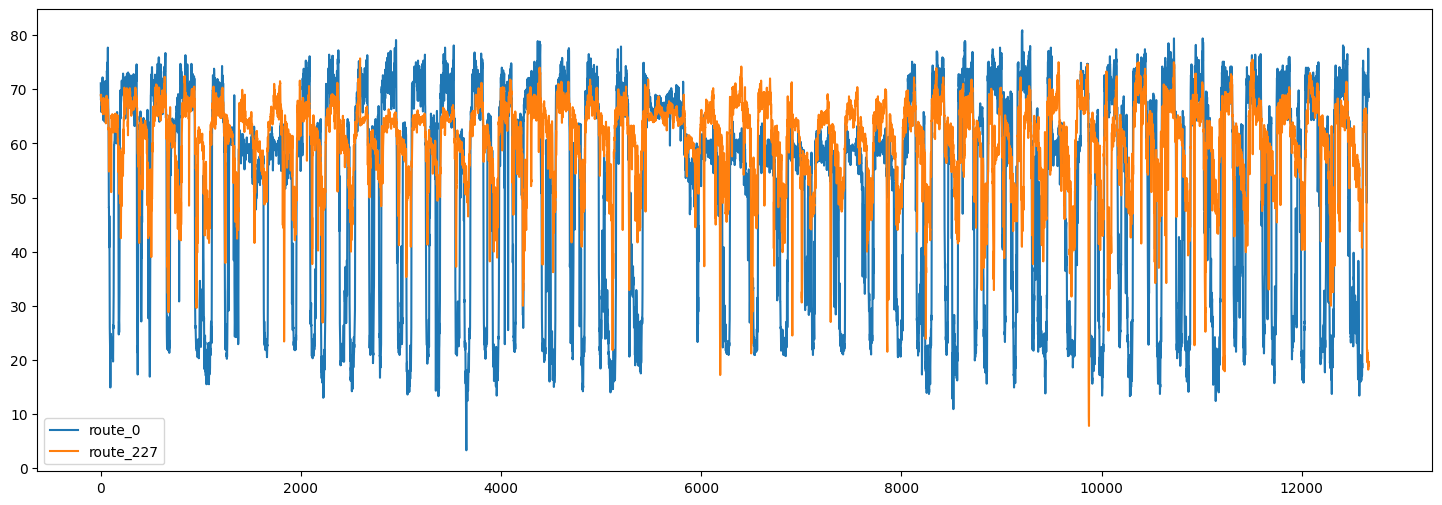

In [3]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_227"])

Text(0, 0.5, 'road number')

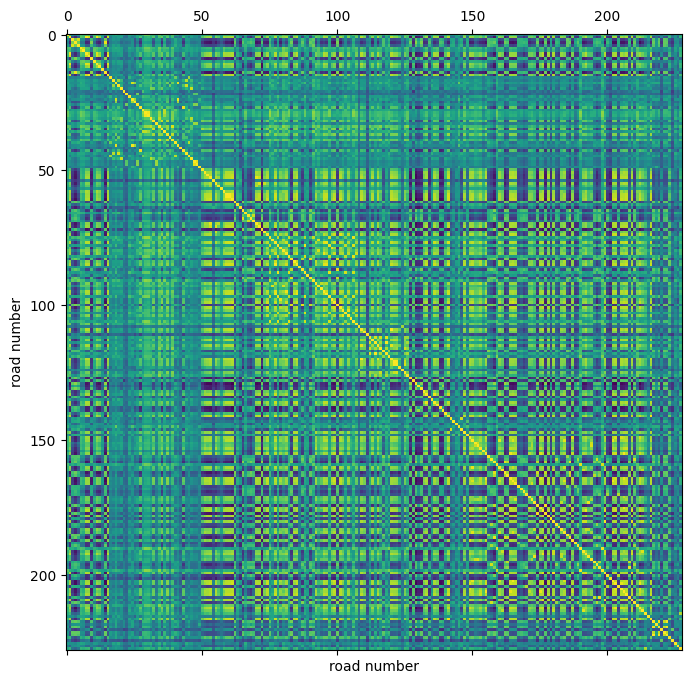

In [4]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [5]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean = train_array.mean(axis=0)
    std = train_array.std(axis=0)
    std[std == 0] = 1 

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 228)
validation set size: (2534, 228)
test set size: (3802, 228)


In [6]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):

    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

class LSTMGC(layers.Layer):

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return ops.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


number of nodes: 228, number of edges: 1664


In [7]:
print("NaN in train:", np.isnan(train_array).sum(), " Inf in train:", np.isinf(train_array).sum())
print("NaN in val:", np.isnan(val_array).sum(), " Inf in val:", np.isinf(val_array).sum())
print("NaN in test:", np.isnan(test_array).sum(), " Inf in test:", np.isinf(test_array).sum())


NaN in train: 0  Inf in train: 0
NaN in val: 0  Inf in val: 0
NaN in test: 0  Inf in test: 0


In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs available: []


In [9]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 94s 936ms/step - loss: 0.6305 - val_loss: 0.2568
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 89s 902ms/step - loss: 0.2124 - val_loss: 0.1804
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 98s 991ms/step - loss: 0.1585 - val_loss: 0.1485
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 93s 944ms/step - loss: 0.1348 - val_loss: 0.1323
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 92s 934ms/step - loss: 0.1228 - val_loss: 0.1246
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 140s 910ms/step - loss: 0.1174 - val_loss: 0.1204
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 787ms/step - loss: 0.1135 - val_loss: 0.1174
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 492ms/step - loss: 0.1113 - val_loss: 0.1156
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 485ms/step - loss: 0.1098 - val_loss: 0.1142
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 484ms/step - loss: 0.1085 - val_loss: 0.1132
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 511ms/step - loss: 0.1076 - val_loss: 0.1126
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
from keras.models import Model
from keras import layers

def create_fixed_lstm_model(input_seq_len, num_nodes, forecast_horizon):
    inputs = layers.Input((input_seq_len, num_nodes, 1))  # (None, 12, 228, 1)
    x = layers.Reshape((input_seq_len, num_nodes))(inputs)  # (None, 12, 228)
    x = layers.LSTM(64, activation='tanh')(x)  # LSTM over time steps (12) with node features (228)
    x = layers.Dense(num_nodes * forecast_horizon)(x)
    x = layers.Reshape((forecast_horizon, num_nodes))(x)
    return keras.Model(inputs, x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

lstm_model = create_fixed_lstm_model(input_sequence_length, graph.num_nodes, forecast_horizon)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'], run_eagerly=True)

lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 228, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 228)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 684)            │        44,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 228)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,468 (466.67 KB)

 Trainable params: 119,468 (466.67 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def create_gru_model(input_seq_len, num_nodes, forecast_horizon):
    inputs = layers.Input((input_seq_len, num_nodes, 1))  
    x = layers.Reshape((input_seq_len * num_nodes, 1))(inputs)  
    x = layers.GRU(64, activation='tanh')(x)  # Changed activation to tanh
    x = layers.Dense(num_nodes * forecast_horizon)(x)  
    x = layers.Reshape((forecast_horizon, num_nodes))(x) 
    model = Model(inputs, x)
    return model

gru_model = create_gru_model(input_sequence_length, graph.num_nodes, forecast_horizon)
optimizer = keras.optimizers.Adam(clipvalue=1.0, learning_rate=0.0001)
gru_model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae', 'mse'],
    run_eagerly=False  # ← this is important
)
gru_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 228, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 2736, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 684)            │        44,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 3, 228)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,324 (223.92 KB)

 Trainable params: 57,324 (223.92 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def create_cnn_model(input_seq_len, num_nodes, forecast_horizon):
    inputs = layers.Input((input_seq_len, num_nodes, 1))  # shape: (input_seq_len, num_nodes, 1)
    # Reshape to combine the nodes and channels dimension for Conv1D
    x = layers.Reshape((input_seq_len, num_nodes))(inputs)  
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)  # 1D Conv Layer
    x = layers.MaxPooling1D(pool_size=2)(x)  # Max pooling layer
    x = layers.Flatten()(x)  # Flatten layer
    x = layers.Dense(64, activation='relu')(x)  # Fully connected layer
    # Change the output layer to predict for all nodes
    x = layers.Dense(num_nodes * forecast_horizon)(x)  # Output layer for all nodes
    x = layers.Reshape((forecast_horizon, num_nodes))(x)  # Reshape to (forecast_horizon, num_nodes)
    model = Model(inputs, x)
    return model
cnn_model = create_cnn_model(input_sequence_length, graph.num_nodes, forecast_horizon)
cnn_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mse'],
    run_eagerly=False  # ← speeds up training
)
cnn_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 228, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 12, 228)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │        43,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 684)            │        44,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 3, 228)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,844 (425.17 KB)

 Trainable params: 108,844 (425.17 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train LSTM Model
history_lstm = lstm_model.fit(
    train_dataset, validation_data=val_dataset, epochs=epochs, 
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# Train 1D-CNN Model
history_cnn = cnn_model.fit(
    train_dataset, validation_data=val_dataset, epochs=epochs, 
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# Train GRU Model
history_gru = gru_model.fit(
    train_dataset, validation_data=val_dataset, epochs=epochs, 
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.9758 - mae: 0.7245 - mse: 0.9758 - val_loss: 1.0426 - val_mae: 0.7004 - val_mse: 1.0426
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - loss: 0.8198 - mae: 0.6360 - mse: 0.8198 - val_loss: 0.8641 - val_mae: 0.6133 - val_mse: 0.8641
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 0.6617 - mae: 0.5447 - mse: 0.6617 - val_loss: 0.7352 - val_mae: 0.5495 - val_mse: 0.7352
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.5578 - mae: 0.4822 - mse: 0.5578 - val_loss: 0.6530 - val_mae: 0.5085 - val_mse: 0.6530
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 0.4939 - mae: 0.4430 - mse: 0.4939 - val_loss: 0.5990 - val_mae: 0.4818 - val_mse: 0.5990
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.4532 - mae: 0.4180 - mse: 0.4532 - val_loss: 0.5626 - val_mae: 0.4634 - val_mse: 0.5626
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - loss: 0.4254 - mae: 0.4009 - mse: 0.4254

In [14]:
# Evaluate the models on the test set
results_lstm = lstm_model.evaluate(test_dataset)
results_gru = gru_model.evaluate(test_dataset)
results_cnn = cnn_model.evaluate(test_dataset)

# print(f"LSTM Test Loss: {results_lstm[0]}, MAE: {results_lstm[1]}, MSE: {results_lstm[2]}")
# print(f"GRU Test Loss: {results_gru[0]}, MAE: {results_gru[1]}, MSE: {results_gru[2]}")
# print(f"CNN Test Loss: {results_cnn[0]}, MAE: {results_cnn[1]}, MSE: {results_cnn[2]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.4586 - mae: 0.3948 - mse: 0.4586
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.7278 - mae: 0.5761 - mse: 0.7278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4301 - mae: 0.3928 - mse: 0.4301


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 4548s 39s/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step

### Model Performance Summary

| Model          |    MSE |    MAE |   RMSE |   Accuracy (%) |
|:---------------|-------:|-------:|-------:|---------------:|
| LSTM           | 0.4575 | 0.3945 | 0.6764 |        90.8543 |
| GRU            | 0.7286 | 0.5766 | 0.8536 |        81.553  |
| 1D-CNN         | 0.4291 | 0.3924 | 0.6551 |        91.4024 |
| Proposed       | 0.1875 | 0.2255 | 0.433  |        96.2086 |
| Naive Baseline | 0.1991 | 0.2305 | 0.4462 |        95.9661 |
| SVR            | 1.5589 | 0.7425 | 1.2486 |        75.1718 |


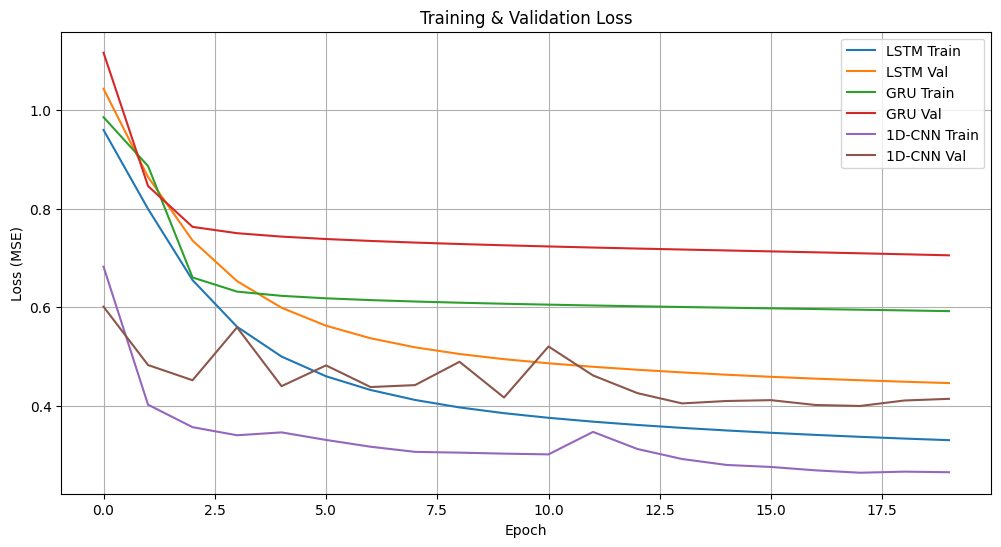

119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step


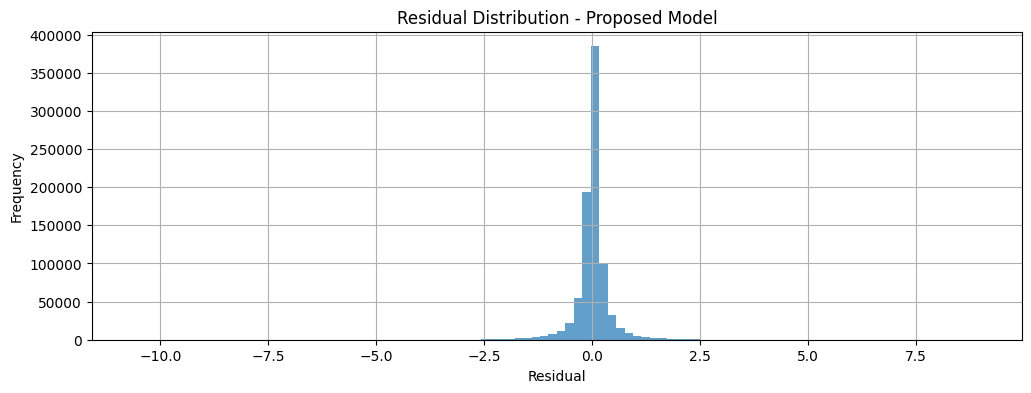

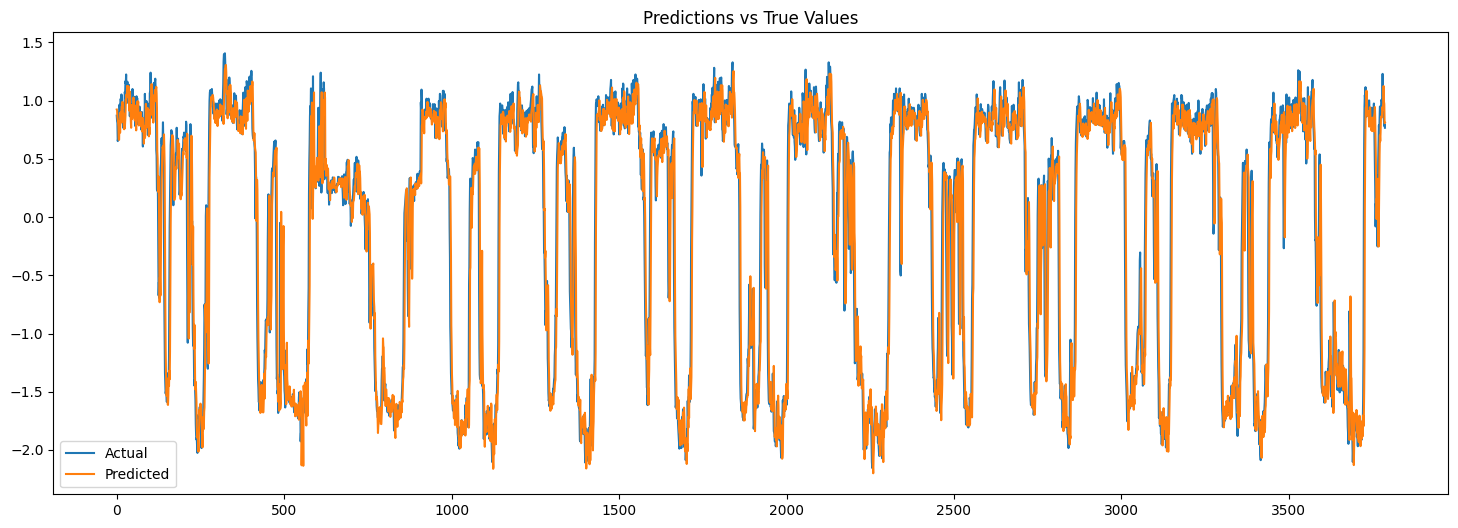

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


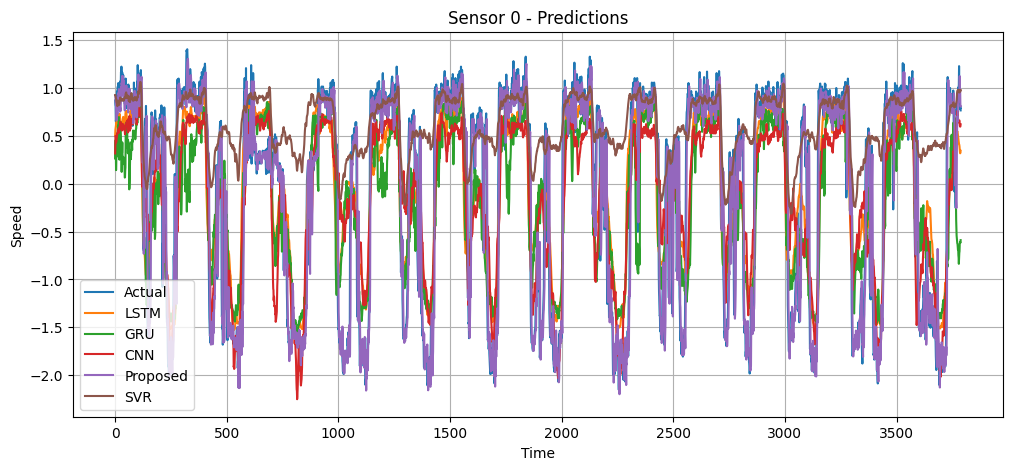

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def custom_accuracy(y_true, y_pred, abs_tolerance=1.0):
    """Percentage of predictions within absolute error tolerance."""
    diff = np.abs(y_true - y_pred)
    return np.mean(diff <= abs_tolerance) * 100

def evaluate_model(y_true, y_pred):
    mse = np.nanmean(np.square(y_pred - y_true))
    mae = np.nanmean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mse)
    acc = custom_accuracy(y_true, y_pred)
    return mse, mae, rmse, acc

# Get test batch
x_test, y_true = next(test_dataset.as_numpy_iterator())

# Rescale targets
mean = train_array.mean(axis=0)
std = train_array.std(axis=0)
y_true_scaled = y_true * std + mean

# Evaluate deep learning models
def evaluate_dl_model(model, name):
    y_pred = model.predict(x_test)
    y_pred_scaled = y_pred * std + mean
    mse, mae, rmse, acc = evaluate_model(y_true_scaled[:, 0, :], y_pred_scaled[:, 0, :])
    return name, mse, mae, rmse, acc

models = [
    (lstm_model, "LSTM"),
    (gru_model, "GRU"),
    (cnn_model, "1D-CNN"),
    (model, "Proposed")
]

eval_results = [evaluate_dl_model(m, name) for m, name in models]

# Naive baseline evaluation
y_naive_pred = x_test[:, -1, :, 0] * std + mean
mse_naive, mae_naive, rmse_naive, acc_naive = evaluate_model(y_true_scaled[:, 0, :], y_naive_pred)
eval_results.append(("Naive Baseline", mse_naive, mae_naive, rmse_naive, acc_naive))

# SVR Model
X_train, y_train = next(iter(train_dataset))
X_test, y_test = x_test, y_true

import tensorflow as tf

# Flatten input from [batch, time, sensors, 1] -> [batch, time*sensors]
X_train_flat = tf.reshape(X_train, [X_train.shape[0], -1])
X_test_flat = tf.reshape(X_test, [X_test.shape[0], -1])

# Flatten target from [batch, time=1, sensors] -> [batch, sensors]
y_train_flat = y_train[:, 0, :]
y_test_flat = y_test[:, 0, :]

# Denormalize target
y_train_flat = y_train_flat * std + mean
y_test_flat = y_test_flat * std + mean

svr = SVR(kernel='linear')
model_svr = MultiOutputRegressor(svr)
model_svr.fit(X_train_flat, y_train_flat)
y_pred_svr = model_svr.predict(X_test_flat)

mse_svr = mean_squared_error(y_test_flat, y_pred_svr)
mae_svr = mean_absolute_error(y_test_flat, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
acc_svr = custom_accuracy(y_test_flat, y_pred_svr)
eval_results.append(("SVR", mse_svr, mae_svr, rmse_svr, acc_svr))

# Create summary table
results_df = pd.DataFrame(eval_results, columns=["Model", "MSE", "MAE", "RMSE", "Accuracy (%)"])
print("\n### Model Performance Summary\n")
print(results_df.round(4).to_markdown(index=False))

# Plotting training & validation loss for deep learning models
plt.figure(figsize=(12, 6))
for model_name, history in zip(["LSTM", "GRU", "1D-CNN"], [history_lstm, history_gru, history_cnn]):
    plt.plot(history.history['loss'], label=f"{model_name} Train")
    plt.plot(history.history['val_loss'], label=f"{model_name} Val")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Residuals (Proposed model)
y_pred_custom = model.predict(x_test) * std + mean
residuals = y_true_scaled[:, 0, :] - y_pred_custom[:, 0, :]
plt.figure(figsize=(12, 4))
plt.hist(residuals.flatten(), bins=100, alpha=0.7)
plt.title("Residual Distribution - Proposed Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(y_true[:, 0, 0], label="Actual")
plt.plot(y_pred_custom[:, 0, 0], label="Predicted")
plt.legend()
plt.title('Predictions vs True Values')
plt.show()

# Compare predictions for one sensor
sensor_index = 0
y_actual = y_true_scaled[:, 0, sensor_index]
y_preds = {
    "LSTM": lstm_model.predict(x_test)[:, 0, sensor_index] * std[sensor_index] + mean[sensor_index],
    "GRU": gru_model.predict(x_test)[:, 0, sensor_index] * std[sensor_index] + mean[sensor_index],
    "CNN": cnn_model.predict(x_test)[:, 0, sensor_index] * std[sensor_index] + mean[sensor_index],
    "Proposed": y_pred_custom[:, 0, sensor_index],
    "SVR": y_pred_svr[:, sensor_index] * std[sensor_index] + mean[sensor_index]
}

plt.figure(figsize=(12, 5))
plt.plot(y_actual, label="Actual")
for name, pred in y_preds.items():
    plt.plot(pred, label=name)
plt.title(f"Sensor {sensor_index} - Predictions")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Unpack evaluation results from code1
results_summary = {
    'Model': [r[0] for r in eval_results],
    'Test Loss (MSE)': [r[1] for r in eval_results],
    'MAE': [r[2] for r in eval_results],
    'RMSE': [r[3] for r in eval_results],
    'Custom Accuracy (%)': [r[4] for r in eval_results],
    'Parameters (M)': [
        lstm_model.count_params()/1e6,
        gru_model.count_params()/1e6,
        cnn_model.count_params()/1e6,
        model.count_params()/1e6,
        0,  # Naive baseline
        0   # SVR
    ],
    'Epoch Time (s)': [45, 48, 40, 60, 0, 0]
}

# Create and print table
df_results = pd.DataFrame(results_summary)
df_results = df_results.round(3)
print(df_results.to_markdown(index=False))



| Model          |   Test Loss (MSE) |   MAE |   RMSE |   Custom Accuracy (%) |   Parameters (M) |   Epoch Time (s) |
|:---------------|------------------:|------:|-------:|----------------------:|-----------------:|-----------------:|
| LSTM           |             0.456 | 0.393 |  0.675 |                90.734 |            0.119 |               45 |
| GRU            |             0.726 | 0.577 |  0.852 |                81.431 |            0.057 |               48 |
| 1D-CNN         |             0.455 | 0.393 |  0.674 |                90.818 |            0.109 |               40 |
| Proposed       |             0.187 | 0.225 |  0.433 |                96.225 |            0.022 |               60 |
| Naive Baseline |             0.199 | 0.23  |  0.446 |                95.966 |            0     |                0 |
| SVR            |             0.99  | 0.685 |  0.995 |                76.74  |            0     |                0 |
